Import packages

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import datetime as dt

Import data

In [2]:
df = pds.read_csv('../../bus203_all_labelled.csv')

# Ignore all other stuff than the ObservedPositionEvent
df = df[df['event'] == "ObservedPositionEvent"]

One hot encode segments, normalize columns and create final dataset

In [25]:
# Make segments categorical
dataset = pds.get_dummies(df['segment_number'])

# Combine segments, timestamps and time from journey start

# Cyclical timestamps 
dataset['hr_sin'] = np.sin(df.timestamp.str[11:13].astype(int)*(2.*np.pi/24))
dataset['hr_cos'] = np.cos(df.timestamp.str[11:13].astype(int)*(2.*np.pi/24))

# Convert to radians befor trigonometric functions
dataset['dir_sin'] = np.sin(df.direction*(np.pi/180))
dataset['dir_cos'] = np.cos(df.direction*(np.pi/180))

dataset['speed'] = dataset['speed'] = (df['speed']-df['speed'].min())/(df['speed'].max()-df['speed'].min())
dataset['time_since_journey_start'] = (df['time_since_journey_start']-df['time_since_journey_start'].min())/(df['time_since_journey_start'].max()-df['time_since_journey_start'].min())

dataset['latitude'] = (df['latitude']-df['latitude'].min())/(df['latitude'].max()-df['latitude'].min())
dataset['longitude'] = (df['longitude']-df['longitude'].min())/(df['longitude'].max()-df['longitude'].min())

# Include journey number to select entire journeys
dataset['journey_number'] = df['journey_number']

Select an arbitrary number of test journeys

In [26]:
num_test_segments = 100 
msk = np.random.randint(1, dataset.journey_number.unique()[-1], num_test_segments)
mask = dataset['journey_number'].isin(msk)

Divide training and test data, 80% training data

In [27]:
train_input = dataset[~mask]
test_input = dataset[mask]

train_labels = df['label'][~mask]
test_labels = df['label'][mask]

In [28]:
# Journey numbers were needed up until this point
train_data = train_input.drop(columns=['journey_number'])
test_data = test_input.drop(columns=['journey_number'])

Build model

In [31]:
model = keras.Sequential([
	keras.layers.Dense(len(train_data.columns), activation=tf.nn.relu, input_shape=(train_data.shape[1],)),
    keras.layers.Dense(3),
	keras.layers.Dense(1)
	])

optimizer = tf.train.RMSPropOptimizer(0.001)
model.compile(loss='mae', optimizer = optimizer, metrics=['mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 60        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4         
Total params: 444
Trainable params: 444
Non-trainable params: 0
_________________________________________________________________
None


Fit model

In [32]:
EPOCHS=5
model.fit(train_data.values, train_labels.values, epochs = EPOCHS)

Epoch 1/5
3221724/3221724 [==============================] - 51s 16us/step - loss: 17.8788 - mean_absolute_error: 17.8788
Epoch 2/5
3221724/3221724 [==============================] - 51s 16us/step - loss: 17.1062 - mean_absolute_error: 17.1062
Epoch 3/5
3221724/3221724 [==============================] - 51s 16us/step - loss: 17.0894 - mean_absolute_error: 17.0894
Epoch 4/5
3221724/3221724 [==============================] - 50s 16us/step - loss: 17.0643 - mean_absolute_error: 17.0643
Epoch 5/5
3221724/3221724 [==============================] - 51s 16us/step - loss: 17.0372 - mean_absolute_error: 17.0372


Evaluate model

In [33]:
model.evaluate(test_data.values, test_labels.values)

90276/90276 [==============================] - 1s 8us/step


[17.68893736927567, 17.68893736927567]

Roughly the same as the second "base" model.

An arbitrary number from `msk` is chosen, i.e. a journey, to a comparison with original data.

In [ ]:
selected_journey = np.random.choice(msk)
to_test = test_input[test_input['journey_number'] == selected_journey]
model_to_predict = to_test.drop(columns=['journey_number'])
predictions = model.predict(model_to_predict.values, batch_size=1, verbose=1)

In [35]:
journey_ = test_input.index[test_input['journey_number'] == selected_journey]
j_labels = test_labels.loc[journey_]
j_labels = j_labels.reset_index().drop(columns=['index'])

Green line is the predicted time, red is the actual time. Note that the predicted time is the time it takes to drive an entire segment.


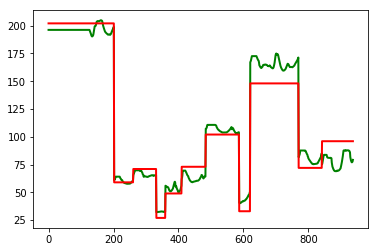

In [36]:
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(j_labels, color='red', linewidth=2, markersize=12)
plt.show()

Note that the plot above contains all 11 segments. The prediction is behaving a little bit different now as it seem to give different predictions for different places within each segment.

Below is a final scatterplot from the entire test data set.

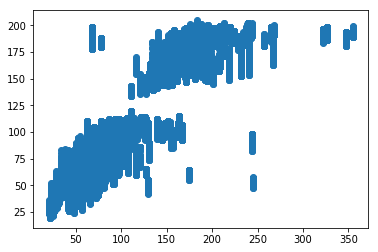

In [24]:
test_predictions = model.predict(test_data.values)
plt.scatter(test_labels.values, test_predictions)
plt.show()